In [441]:
using OrdinaryDiffEq
using ModelingToolkit
using DataDrivenDiffEq
using LinearAlgebra, DiffEqSensitivity, Optim
using DiffEqFlux, Flux
using Plots
using CUDA

# Graphs 
using LightGraphs, SimpleWeightedGraphs
using GraphPlot, GraphRecipes
gr()

Plots.GRBackend()

## Kuramoto oscillators

## $$
\begin{aligned}
  \dot{\theta_{i}} &= \omega_{i} + \sum_{j=0}^{N} a_{ij} \sin(\theta_{j} - \theta_{i})\\
\end{aligned}
$$


## Define the graph

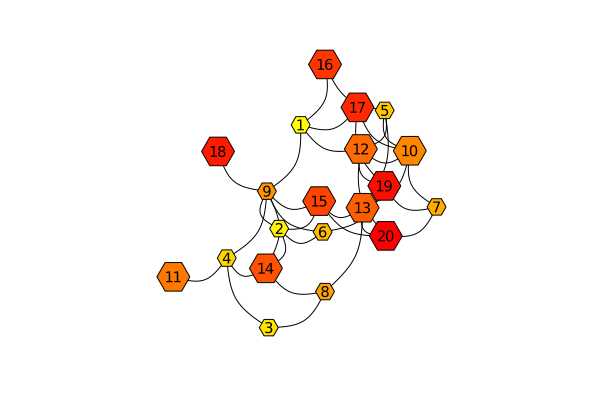

In [431]:
N = 20
G = SimpleGraph(N)

for i ∈ 1:N
    for j ∈ i:N
        if i != j && rand((0,1,2,3,4)) == 1
            add_edge!(G, i, j)
        end
    end
end

graphplot(G,
          markersize = 0.2,
          markercolor = range(colorant"yellow", stop=colorant"red", length=N),
          names = 1:N,
          fontsize = 10,
          linecolor = :darkgrey
          )

## Adjacency matrix

In [432]:
A = adjacency_matrix(G)
Array(A[:,1]);

## Extract the subgraph of known couplings

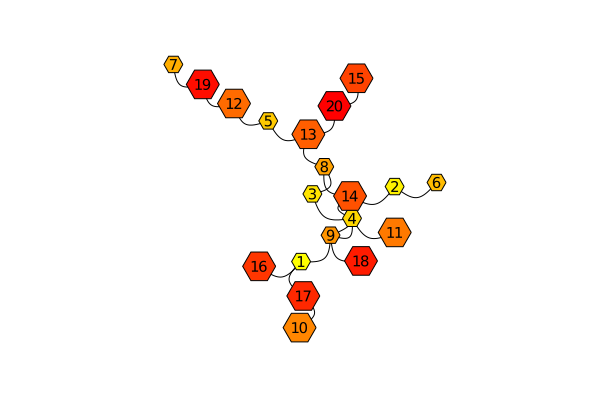

In [487]:
#known interactions
#elist = [Edge(9,18), Edge(4,11), Edge(3,4)]


Gₖ = SimpleGraph(N)

for i in edges(G)
    if rand((0,1)) == 1
        add_edge!(Gₖ, i)
    end
end

graphplot(Gₖ,
          markersize = 0.2,
          markercolor = range(colorant"yellow", stop=colorant"red", length=N),
          names = 1:N,
          fontsize = 10,
          linecolor = :darkgrey)

## Adjacency matrix for the known interactions

In [488]:
Aₖ = adjacency_matrix(Gₖ)
Array(Aₖ[:,19]);

## ODE

In [489]:
function Kuramoto(du, u, A, t)
    
    S = [sin(u[j] - u[i]) for i ∈ 1:N, j ∈ 1:N]
    
    du[1] =  (1/(count(i->(i>0), Array(A[:,1]))))*(S*Array(A[:,1]))[1]
    du[2] =  (1/(count(i->(i>0), Array(A[:,2]))))*(S*Array(A[:,2]))[2]
    du[3] =  (1/(count(i->(i>0), Array(A[:,3]))))*(S*Array(A[:,3]))[3]
    du[4] =  (1/(count(i->(i>0), Array(A[:,4]))))*(S*Array(A[:,4]))[4]
    du[5] =  (1/(count(i->(i>0), Array(A[:,5]))))*(S*Array(A[:,5]))[5]
    du[6] =  (1/(count(i->(i>0), Array(A[:,6]))))*(S*Array(A[:,6]))[6]
    du[7] =  (1/(count(i->(i>0), Array(A[:,7]))))*(S*Array(A[:,7]))[7]
    du[8] =  (1/(count(i->(i>0), Array(A[:,8]))))*(S*Array(A[:,8]))[8]
    du[9] =  (1/(count(i->(i>0), Array(A[:,9]))))*(S*Array(A[:,9]))[9]
    du[10] =  (1/(count(i->(i>0), Array(A[:, 10]))))*(S*Array(A[:,10]))[10]
    du[11] =  (1/(count(i->(i>0), Array(A[:,11]))))*(S*Array(A[:,11]))[11]
    du[12] =  (1/(count(i->(i>0), Array(A[:,12]))))*(S*Array(A[:,12]))[12]
    du[13] =  (1/(count(i->(i>0), Array(A[:,13]))))*(S*Array(A[:,13]))[13]
    du[14] =  (1/(count(i->(i>0), Array(A[:,14]))))*(S*Array(A[:,14]))[14]
    du[15] =  (1/(count(i->(i>0), Array(A[:,15]))))*(S*Array(A[:,15]))[15]
    du[16] =  (1/(count(i->(i>0), Array(A[:,16]))))*(S*Array(A[:,16]))[16]
    du[17] =  (1/(count(i->(i>0), Array(A[:,17]))))*(S*Array(A[:,17]))[17]
    du[18] =  (1/(count(i->(i>0), Array(A[:,18]))))*(S*Array(A[:,18]))[18]
    du[19] =  (1/(count(i->(i>0), Array(A[:,19]))))*(S*Array(A[:,19]))[19]
    du[20] =  (1/(count(i->(i>0), Array(A[:,20]))))*(S*Array(A[:,20]))[20]

end

# Define the experimental parameter

tspan = (0.0f0, 5.0f0)
u0 = 2*randn(Float32, (N,))
prob = ODEProblem(Kuramoto, u0, tspan, A)

saveat = 0.03
solution = solve(prob, Vern7(), saveat = saveat) #abstol=1e-12, reltol=1e-12,

X = Array(solution)

# Add noise to the data
println("Generate noisy data")
Xₙ = X + Float32(1e-4)*randn(eltype(X), size(X));

Generate noisy data


## Plot the training data

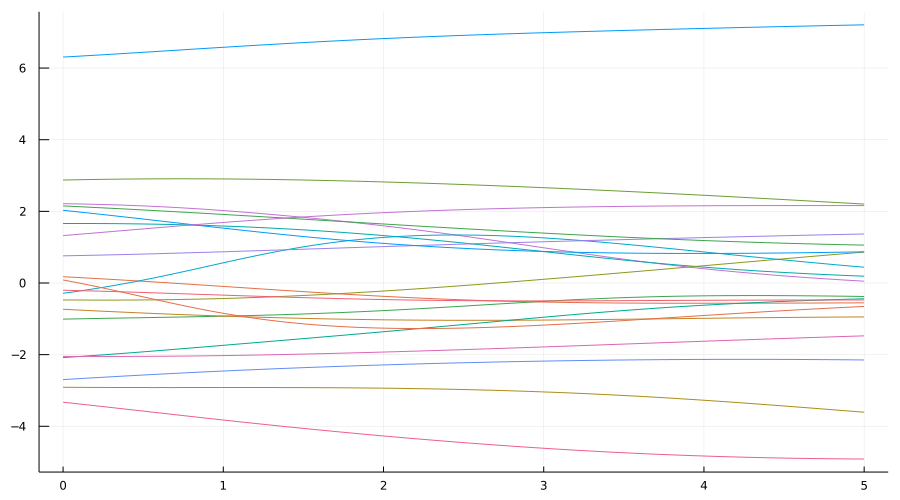

In [490]:
width = 900
height = 500

#plot(solution)
#plot(Array(solution)[1, :], Array(solution)[2, :])
#plot(Xₙ[1, :], Xₙ[2, :])

plot(solution.t, Xₙ[1, :], size = (width, height), label = false) #, label = "1", legend=:topleft,
for i ∈ 2:(N-1)
    plot!(solution.t, Xₙ[i, :], label = false) #, label = "$i"
end
plot!(solution.t, Xₙ[N, :], label = false) #, label = "$N"


## In the phase space

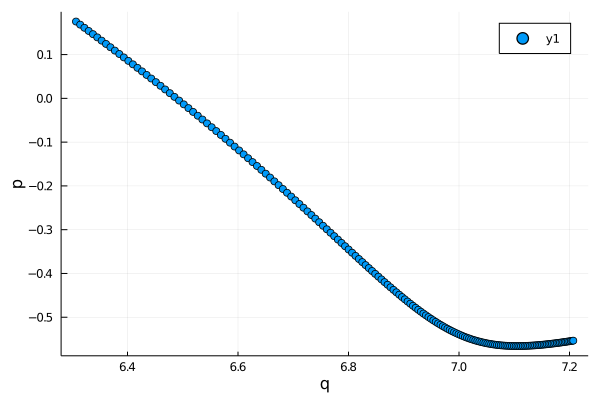

In [491]:
scatter(Array(solution)[1, :], Array(solution)[2, :], xlabel = "q", ylabel = "p")

## UADE

In [502]:
# Neural network

L = FastChain(FastDense(20, 30, tanh), FastDense(30, 30, tanh), FastDense(30, 30, tanh), FastDense(30, 20))  |> gpu
p = initial_params(L)



# ODE
function dudt_(u, p, t)
    
    S = [sin(u[j] - u[i]) for i ∈ 1:N, j ∈ 1:N]
    
    z = L(u,p)
    
    [(1/(count(i->(i>0), Array(Aₖ[:,1]))))*(S*Array(Aₖ[:,1]))[1] + z[1],
    (1/(count(i->(i>0), Array(Aₖ[:,2]))))*(S*Array(Aₖ[:,2]))[2] + z[2],
    (1/(count(i->(i>0), Array(Aₖ[:,3]))))*(S*Array(Aₖ[:,3]))[3] + z[3],
    (1/(count(i->(i>0), Array(Aₖ[:,4]))))*(S*Array(Aₖ[:,4]))[4] + z[4],
    (1/(count(i->(i>0), Array(Aₖ[:,5]))))*(S*Array(Aₖ[:,5]))[5] + z[5],
    (1/(count(i->(i>0), Array(Aₖ[:,6]))))*(S*Array(Aₖ[:,6]))[6] + z[6],
    (1/(count(i->(i>0), Array(Aₖ[:,7]))))*(S*Array(Aₖ[:,7]))[7] + z[7],
    (1/(count(i->(i>0), Array(Aₖ[:,8]))))*(S*Array(Aₖ[:,8]))[8] + z[8],
    (1/(count(i->(i>0), Array(Aₖ[:,9]))))*(S*Array(Aₖ[:,9]))[9] + z[9],
    (1/(count(i->(i>0), Array(Aₖ[:,10]))))*(S*Array(Aₖ[:,10]))[10] + z[10],
    (1/(count(i->(i>0), Array(Aₖ[:,11]))))*(S*Array(Aₖ[:,11]))[11] + z[11],
    (1/(count(i->(i>0), Array(Aₖ[:,12]))))*(S*Array(Aₖ[:,12]))[12] + z[12],
    (1/(count(i->(i>0), Array(Aₖ[:,13]))))*(S*Array(Aₖ[:,13]))[13] + z[13],
    (1/(count(i->(i>0), Array(Aₖ[:,14]))))*(S*Array(Aₖ[:,14]))[14] + z[14],
    (1/(count(i->(i>0), Array(Aₖ[:,15]))))*(S*Array(Aₖ[:,15]))[15] + z[15],
    (1/(count(i->(i>0), Array(Aₖ[:,16]))))*(S*Array(Aₖ[:,16]))[16] + z[16],
    (1/(count(i->(i>0), Array(Aₖ[:,17]))))*(S*Array(Aₖ[:,17]))[17] + z[17],
    (1/(count(i->(i>0), Array(Aₖ[:,18]))))*(S*Array(Aₖ[:,18]))[18] + z[18],
    (1/(count(i->(i>0), Array(Aₖ[:,19]))))*(S*Array(Aₖ[:,19]))[19] + z[19],
    (1/(count(i->(i>0), Array(Aₖ[:,20]))))*(S*Array(Aₖ[:,20]))[20] + z[20]]
    
end

# ODE problem
prob_nn = ODEProblem(dudt_, u0, tspan, p)
sol_nn = solve(prob_nn, Tsit5(), u0 = u0, p = p, saveat = solution.t);

## Plot the untrained solution

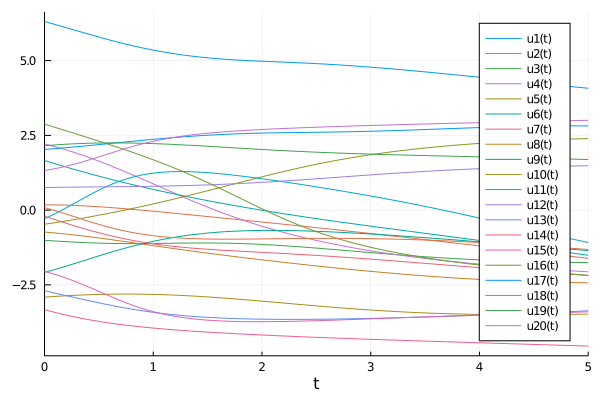

In [503]:
plot(sol_nn)
#plot(Array(sol_nn)[1, :], Array(sol_nn)[2, :])

## Loss function

In [504]:
# This function is used in the loss
function predict(θ)
    Array(solve(prob_nn, Vern7(), u0 = u0, p=θ, saveat = solution.t,
                         abstol=1e-6, reltol=1e-6,
                         sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP())))
end


# No regularisation right now
function loss(θ)
    pred = predict(θ)
    sum(abs2, Xₙ .- pred)
end


# Test
#loss(p)


const losses = []

# The callback function is cb(p,args...) where the arguments are the extra returns from the loss
callback(θ, l) = begin
    push!(losses, l)
    if length(losses)%10==0
        println("Current loss after $(length(losses)) iterations: $(losses[end])")    
    end
    
    # The callback function must return a boolean where if true, then the optimizer will prematurely end the optimization
    false
end

callback (generic function with 1 method)

## Training with ADAM

In [505]:
# Train with ADAM
res1 = DiffEqFlux.sciml_train(loss, p, ADAM(0.01), cb=callback, maxiters = 10)

loss: 1.43e+03: 100%|███████████████████████████████████| Time: 0:12:24


Current loss after 10 iterations: 1429.7251


 * Status: success

 * Candidate solution
    Final objective value:     1.429725e+03

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   838  (vs limit Inf)
    Iterations:    10
    f(x) calls:    10
    ∇f(x) calls:   10


## Training with BFGS

In [206]:
res2 = DiffEqFlux.sciml_train(loss, res1.minimizer, BFGS(initial_stepnorm=0.01), cb=callback, maxiters = 50)

Current loss after 110 iterations: 0.19271168
Current loss after 120 iterations: 0.10212062


 * Status: failure

 * Candidate solution
    Final objective value:     7.441945e-02

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 6.31e-03 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.25e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.00e-03 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.72e-02 ≰ 0.0e+00
    |g(x)|                 = 2.34e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   39  (vs limit Inf)
    Iterations:    23
    f(x) calls:    50
    ∇f(x) calls:   50


## Plot the loss

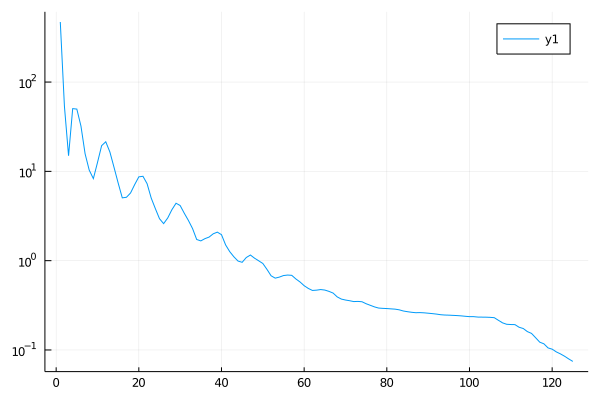

In [207]:
plot(losses, yaxis=:log)

## Plot the prediction

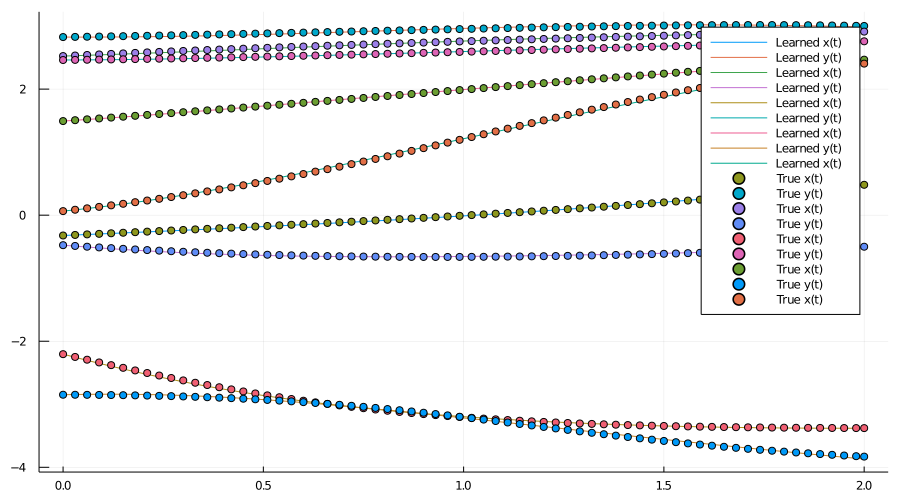

In [208]:
NNsolution = predict(res2.minimizer)
# Trained on noisy data vs real solution
plot(solution.t, NNsolution', label = ["Learned x(t)" "Learned y(t)"], size = (width, height))
scatter!(solution.t, X', label = ["True x(t)" "True y(t)"])

## Prediction

In [210]:
function dudt_2(u, p, t)
    x1, x2, x3, x4, x5, x6, x7, x8, x9 = u
    z = L(u,p)
    [z[1],
    z[2],
    z[3],
    z[4],
    z[5],
    z[6],
    z[7],
    z[8],
    z[9]]
end

# ODE problem
tspan2 = (0.0f0, 6.0f0)
prob_nn2 = ODEProblem(dudt_2, u0, tspan2, res2.minimizer)
sol_nn2 = solve(prob_nn2, Tsit5(), u0 = u0, saveat = saveat);

## Test the prediction

In [214]:
prob_test = ODEProblem(Kuramoto, u0, tspan2, p_)
solution_test = solve(prob_test, Vern7(), saveat = saveat);

## Prot together true and prediction

## Plot $q(t)$ and $p(t)$

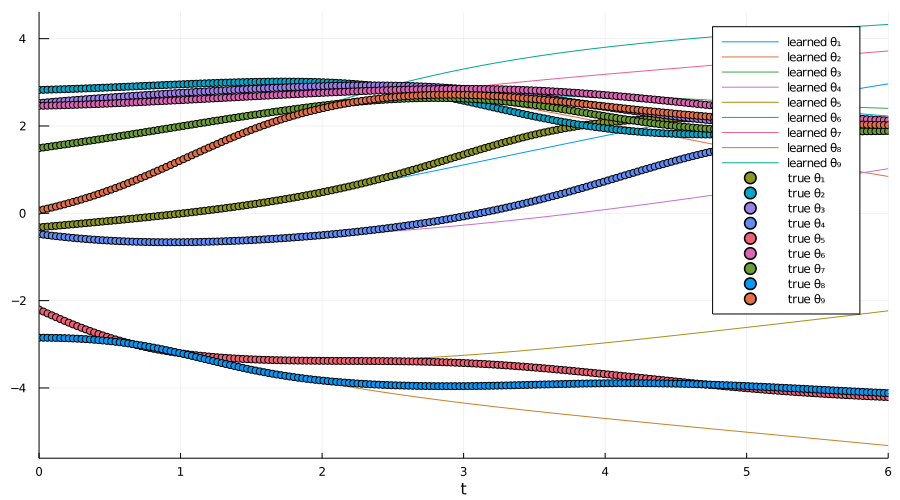

In [224]:
plot(sol_nn2, label = ["learned θ₁" "learned θ₂" "learned θ₃" "learned θ₄" "learned θ₅" "learned θ₆" "learned θ₇" "learned θ₈" "learned θ₉"], size = (width, height))
scatter!(solution_test.t, Array(solution_test)[1, :], label = "true θ₁")
scatter!(solution_test.t, Array(solution_test)[2, :], label = "true θ₂")
scatter!(solution_test.t, Array(solution_test)[3, :], label = "true θ₃")
scatter!(solution_test.t, Array(solution_test)[4, :], label = "true θ₄")
scatter!(solution_test.t, Array(solution_test)[5, :], label = "true θ₅")
scatter!(solution_test.t, Array(solution_test)[6, :], label = "true θ₆")
scatter!(solution_test.t, Array(solution_test)[7, :], label = "true θ₇")
scatter!(solution_test.t, Array(solution_test)[8, :], label = "true θ₈")
scatter!(solution_test.t, Array(solution_test)[9, :], label = "true θ₉")

--------------------------------------------------------
--------------------------------------------------------
--------------------------------------------------------

# SINDy Sparse Identification of Non-linear Dynamics
### Ideal derivatives:
### we take derivatives with respect to $t$ of $(x(t), y(t))$ both from the known solution and the solution to the trained UADE

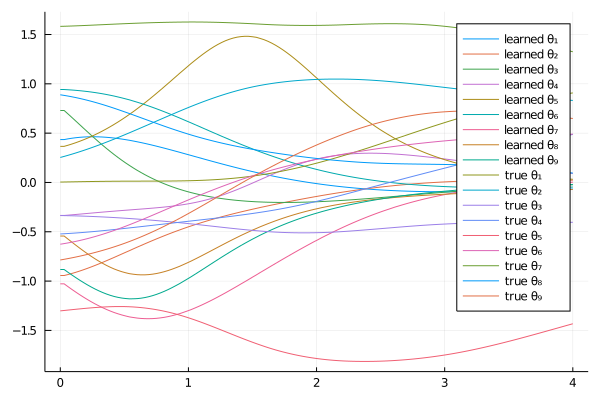

In [253]:
DX = Array(solution(solution.t, Val{1})) 

prob_nn2 = ODEProblem(dudt_2, u0, tspan, res2.minimizer)
_sol = solve(prob_nn2, Tsit5())

DX_ = Array(_sol(solution.t, Val{1}))

plot(solution.t, DX', label = ["learned θ₁" "learned θ₂" "learned θ₃" "learned θ₄" "learned θ₅" "learned θ₆" "learned θ₇" "learned θ₈" "learned θ₉"])
plot!(solution.t, DX_', label = ["true θ₁" "true θ₂" "true θ₃" "true θ₄" "true θ₅" "true θ₆" "true θ₇" "true θ₈" "true θ₉"])

## The learned derivatives

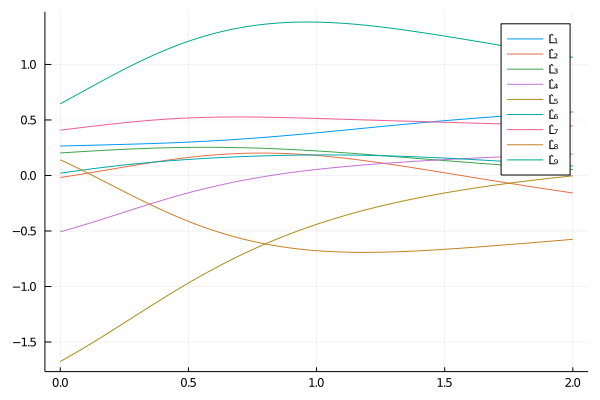

In [228]:
# Ideal data
#L̄ = [(Xₙ[2,:]/(p_[1]*p_[2]^(2)))'; -p_[1]*p_[2]*p_[3]*sin.(Xₙ[1,:]')]

# Neural network guess
L̂ = L(Xₙ, res2.minimizer)

#scatter(solution.t, L̄', label = ["L̄₁" "L̄₂" "L̄₃" "L̄₄" "L̄₅" "L̄₆" "L̄₇" "L̄₈" "L̄₉"])
plot(solution.t, L̂', label = ["L̂₁" "L̂₂" "L̂₃" "L̂₄" "L̂₅" "L̂₆" "L̂₇" "L̂₈" "L̂₉"])


#savefig("UADE.png")

# Plot the error
#scatter(abs.(L̄-L̂)', yaxis = :log)

## Create a basis for the sparse identification

In [230]:
@variables u[1:9]

# Lots of polynomials
ops = Operation[1]

for i ∈ 1:9
    for j ∈ i:9
        if i != j
            push!(ops, sin(u[i] - u[j]))
        end
    end
end

# And some other stuff
h = [ops...]
basis = Basis(h, u)

37 dimensional basis in ["u₁", "u₂", "u₃", "u₄", "u₅", "u₆", "u₇", "u₈", "u₉"]

## Optimizer for the algorithm

In [232]:
opt = SR3() 
#opt = STRRidge(0.1)


# Create the thresholds which should be used in the search process
λ = exp10.(-5:0.1:5)

# Target function to choose the results from; x = L0 of coefficients and L2-Error of the model
g(x) = x[1] < 1 ? Inf : norm(x, 2)

#Suggestion from AlCap23
#g(x) = x[1] < 1 ? Inf : norm([0.1; 10.0] .* x, 2)

g (generic function with 1 method)

## Test on original data and without further knowledge (fail)

In [254]:
println("SINDy on full ideal, unavailable data")
Ψ = SINDy(Xₙ[:, :], DX[:, :], basis, λ, opt, g = g, maxiter = 50000) # Fail
println(Ψ)
print_equations(Ψ)

SINDy on full ideal, unavailable data
Sparse Identification Result
No. of Parameters : 14
Active terms : 14
   Equation 1 : 1
   Equation 2 : 1
   Equation 3 : 1
   Equation 4 : 2
   Equation 5 : 2
   Equation 6 : 1
   Equation 7 : 4
   Equation 8 : 1
   Equation 9 : 1
Overall error (L2-Norm) : 16.231901
   Equation 1 : 0.111663446
   Equation 2 : 1.9661889
   Equation 3 : 0.099619135
   Equation 4 : 1.1432382
   Equation 5 : 2.862074
   Equation 6 : 0.35740933
   Equation 7 : 1.7041503
   Equation 8 : 2.0595655
   Equation 9 : 5.9279923
AICC :
   Equation 1 : 10.859973
   Equation 2 : -0.6134793
   Equation 3 : 11.316513
   Equation 4 : 3.647747
   Equation 5 : -0.02297971
   Equation 6 : 6.2064033
   Equation 7 : 6.3328495
   Equation 8 : -0.799071
   Equation 9 : -5.0278335

SR3{Float64,UnionAll}(0.3154786722400966, 1.0, ProximalOperators.NormL1) converged after 7956 iterations.

9 dimensional basis in ["u₁", "u₂", "u₃", "u₄", "u₅", "u₆", "u₇", "u₈", "u₉"]
du₁ = p₁ * sin(-1u₃ + u₁)


## Test on UADE derivative data

In [233]:
println("SINDy on learned, partial, available data")
Ψ = SINDy(Xₙ[:, 2:end], L̂[:, 2:end], basis, λ,  opt, g = g, maxiter = 50000, normalize = true, denoise = true)
println(Ψ)
print_equations(Ψ)

SINDy on learned, partial, available data
Sparse Identification Result
No. of Parameters : 13
Active terms : 13
   Equation 1 : 1
   Equation 2 : 1
   Equation 3 : 1
   Equation 4 : 2
   Equation 5 : 2
   Equation 6 : 1
   Equation 7 : 1
   Equation 8 : 2
   Equation 9 : 2
Overall error (L2-Norm) : 13.355528
   Equation 1 : 2.5896833
   Equation 2 : 1.1707206
   Equation 3 : 1.2283653
   Equation 4 : 0.38742688
   Equation 5 : 0.5047346
   Equation 6 : 0.8136021
   Equation 7 : 3.3593397
   Equation 8 : 1.4578966
   Equation 9 : 1.8437593
AICC :
   Equation 1 : -1.6186426
   Equation 2 : 1.5570223
   Equation 3 : 1.3647628
   Equation 4 : 8.173865
   Equation 5 : 7.1158423
   Equation 6 : 3.0126357
   Equation 7 : -2.6594777
   Equation 8 : 2.8729734
   Equation 9 : 1.9337261

SR3{Float64,UnionAll}(0.19905358527674863, 1.0, ProximalOperators.NormL1) converged after 16866 iterations.

9 dimensional basis in ["u₁", "u₂", "u₃", "u₄", "u₅", "u₆", "u₇", "u₈", "u₉"]
du₁ = p₁ * sin(-1u₂ + u₁)

## Extract the parameters

In [255]:
p̂ = parameters(Ψ)
println("First parameter guess : $(p̂)")

First parameter guess : Float32[-0.96555394, -0.76013964, 0.98906356, 0.15201946, 1.1698142, 0.2386253, 0.91897637, 0.94067514, 0.5393447, 0.23502429, 0.14268371, 0.2948936, 0.6306754, 0.24144149]


## Define the ODE with the new identified unknown term

In [256]:
unknown_sys = ODESystem(Ψ)
unknown_eq = ODEFunction(unknown_sys);

In [259]:
function dudt(du, u, p, t)
    p1, p2, p3, p4, p5, p6, p7, p8, p9 = p
    z = unknown_eq(u, [p1; p2; p3; p4; p5; p6; p7; p8; p9], t)
    du[1] = z[1]
    du[2] = z[2]
    du[3] = z[3]
    du[4] = z[4]
    du[5] = z[5]
    du[6] = z[6]
    du[7] = z[7]
    du[8] = z[8]
    du[9] = z[9]
end


dudt (generic function with 1 method)

## Create the approximated problem and solution

┌ Warning: Instability detected. Aborting
└ @ DiffEqBase C:\Users\valpe\.julia\packages\DiffEqBase\3iigH\src\integrator_interface.jl:349


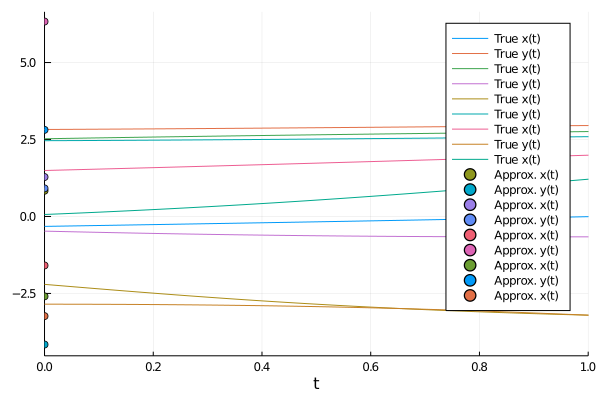

In [262]:
#ps = [p_[[1,2]]; p̂]
tspan = (0.0f0, 1.0f0)
approximate_prob = ODEProblem(dudt, u0, tspan, p̂)
approximate_solution = solve(approximate_prob, Tsit5(), saveat = 0.1)

# Plot
plot(solution_test, label = ["True x(t)" "True y(t)"])
scatter!(approximate_solution, label = ["Approx. x(t)" "Approx. y(t)"])